### First, let's import the necessary libraries.

In [2]:
import numpy as np
import time
import gym
from gym import spaces
from IPython.display import clear_output
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
plt.style.use('dark_background')


### Now, let's create our custom `DisasterZone` gym environment.

In [3]:
class DisasterZone(gym.Env):

    metadata = {'render.modes': ['human']}

    def __init__(self, grid_size=10, num_obstacles=15, num_survivors=5, num_charging_stations=3, max_battery_life=50):

        super(DisasterZone, self).__init__()

        self.grid_size = grid_size
        self.num_obstacles = num_obstacles
        self.num_survivors = num_survivors
        self.num_charging_stations = num_charging_stations
        self.max_battery_life = max_battery_life

        # 0: Up, 1: Down, 2: Left, 3: Right
        self.action_space = spaces.Discrete(4)
        # 0: Empty, 1: Obstacle, 2: Survivor, 3: Charging Station
        self.observation_space = spaces.Box(
            low=0, high=3, shape=(grid_size, grid_size), dtype=np.int32)

        self.reset()

    def reset(self):
        self.grid = np.zeros((self.grid_size, self.grid_size), dtype=np.int32)
        self.agent_pos = (0, 0)
        self.survivors = {}
        self.battery_life = self.max_battery_life

        # Randomly placing obstacles in the grid
        for _ in range(self.num_obstacles):
            pos = self._random_empty_position()
            self.grid[pos] = 1

        # Randomly placing survivors in the grid
        for i in range(self.num_survivors):
            pos = self._random_empty_position()
            self.grid[pos] = 2
            self.survivors[pos] = i

        # Randomly placing charging stations in the grid
        for _ in range(self.num_charging_stations):
            pos = self._random_empty_position()
            self.grid[pos] = 3

        return self.grid

    def step(self, action):
        new_pos = self.agent_pos
        # Default battery consumption for moving to a new position
        battery_consumption = 1

        if action == 0:  # Up
            new_pos = (max(self.agent_pos[0] - 1, 0), self.agent_pos[1])
        elif action == 1:  # Down
            new_pos = (
                min(self.agent_pos[0] + 1, self.grid_size - 1), self.agent_pos[1])
        elif action == 2:  # Left
            new_pos = (self.agent_pos[0], max(self.agent_pos[1] - 1, 0))
        elif action == 3:  # Right
            new_pos = (self.agent_pos[0], min(
                self.agent_pos[1] + 1, self.grid_size - 1))

        # Check if the new position is the same as the current position
        if new_pos == self.agent_pos:
            return self.grid, -1, False, {}

        # Reward for moving into an empty cell
        reward = -2
        done = False

        if self.grid[new_pos] == 1:
            reward = -3
        elif self.grid[new_pos] == 2:
            euclidean_distance = np.linalg.norm(
                np.array(new_pos) - np.array(self.agent_pos))
            reward = max(10 - int(euclidean_distance), 1)
            self.grid[new_pos] = 0
            del self.survivors[new_pos]
            done = len(self.survivors) == 0
        elif self.grid[new_pos] == 3:
            # Charging the battery instead of consuming it
            battery_consumption = -3

        # Update agent's battery life
        self.battery_life -= battery_consumption

        # Check if the battery life has run out
        if self.battery_life <= 0:
            done = True

        # Calculate reward penalty for low battery life
        reward -= self.max_battery_life - self.battery_life

        # Update agent's position
        self.agent_pos = new_pos

        return self.grid, reward, done, {}

    def render(self, mode='human'):
        grid = self.grid.copy()
        grid[self.agent_pos] = 4

        symbol_mapping = {0: '.', 1: 'X', 2: 'S', 3: 'C', 4: 'A'}
        for row in grid:
            print(' '.join([symbol_mapping[cell] for cell in row]))
            print()

    def close(self):
        pass

    def _random_empty_position(self):
        # Finding all the empty positions in the grid where it's not the top-left corner
        empty_positions = np.argwhere((self.grid == 0) & (
            np.arange(self.grid.size).reshape(self.grid.shape) != 0))
        return tuple(empty_positions[np.random.randint(len(empty_positions))])


### Let's create a Q-learning agent to learn a policy in the `DisasterZone`. The agent will learn a Q-table that represents the expected future rewards for each state-action pair.

In [4]:
class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = {}

    def _state_key(self, state, agent_pos):
        return (tuple(state.flatten()), agent_pos)

    def _get_q(self, state, agent_pos, action):
        state_key = self._state_key(state, agent_pos)
        if state_key not in self.q_table:
            self.q_table[state_key] = np.zeros(self.env.action_space.n)
        return self.q_table[state_key]

    def _choose_action(self, state, agent_pos):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        else:
            q_values = self._get_q(state, agent_pos, None)
            return np.argmax(q_values)

    def _update_q(self, state, agent_pos, action, next_state, next_agent_pos, reward, done):
        q_values = self._get_q(state, agent_pos, action)
        next_q_values = self._get_q(next_state, next_agent_pos, None)
        next_action = self._choose_action(next_state, next_agent_pos)

        if done:
            q_values[action] += self.alpha * (reward - q_values[action])
        else:
            q_values[action] += self.alpha * \
                (reward + self.gamma *
                 next_q_values[next_action] - q_values[action])

    def learn(self, num_episodes):
        rewards = []
        for episode in range(num_episodes):
            state = self.env.reset()
            done = False
            episode_reward = 0

            while not done:
                action = self._choose_action(state, self.env.agent_pos)
                next_state, reward, done, _ = self.env.step(action)
                self._update_q(state, self.env.agent_pos, action,
                               next_state, self.env.agent_pos, reward, done)
                state = next_state

                episode_reward += reward

                self.env.render(mode='human')
                print(
                    f"Step Reward: {reward}, Cumulative Episode Reward: {episode_reward}, Battery Life: {self.env.battery_life}, Survivors Left: {len(self.env.survivors)}")
                print()

                clear_output(wait=True)

                if not done:
                    time.sleep(0.8)

            rewards.append(episode_reward)

            print(
                f"#### Episode {episode + 1}/{num_episodes} finished with cumulative reward: {episode_reward} and survivors rescue rate: {1 - len(self.env.survivors) / self.env.num_survivors} ####")
            time.sleep(1)
            print()
            clear_output(wait=True)

            # Print final episode stats
            if episode == num_episodes - 1:
                print(
                    f"#### Episode {episode + 1}/{num_episodes} finished with cumulative reward: {episode_reward} and survivors rescue rate: {1 - len(self.env.survivors) / self.env.num_survivors} ####")
        return rewards

    def train(self, num_episodes):
        return self.learn(num_episodes)

    def get_q_table(self):
        return self.q_table


### Now, let's instantiate a `DisasterZone` environment and a Q-learning agent to learn a policy in the `DisasterZone`. The agent will learn a Q-table that represents the expected future rewards for each state-action pair.

#### Episode 100/100 finished with cumulative reward: 699 and survivors rescue rate: 1.0 ####


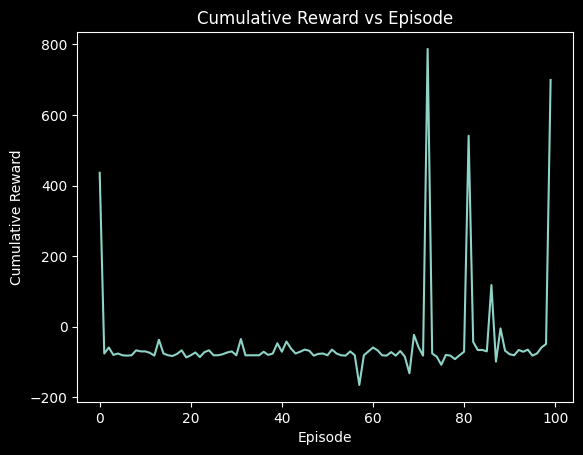

In [14]:
env = DisasterZone(grid_size=4, num_obstacles=5, num_survivors=4,
                   num_charging_stations=2, max_battery_life=10)

agent = QLearningAgent(env)

num_episodes = 100

rewards = agent.train(num_episodes)

plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward vs Episode')
plt.show()


### The previous results aren't that great, hence, let's train the Q-learning agent for an intensive 1 million episodes.

#### Episode 1000000/1000000 finished with cumulative reward: -67 and survivors rescue rate: 0.25 ####


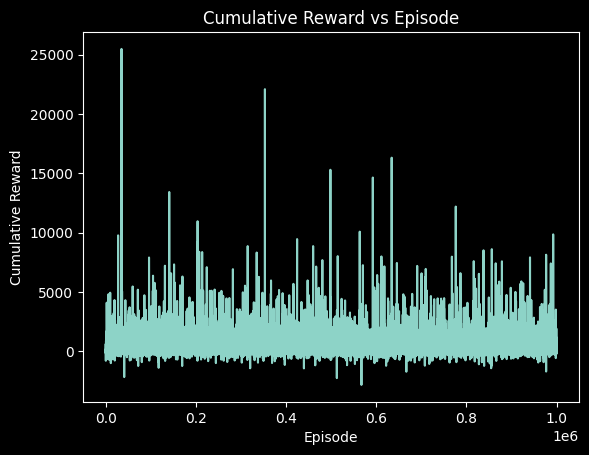

In [18]:
num_episodes = 1000000

rewards = agent.train(num_episodes)

plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward vs Episode')
plt.show()


### After training the Q-learning agent, we can extract symbolic knowledge in the form of IF-THEN rules from the learned Q-table. We can cluster states based on their Q-values and generate rules that represent the best action for a given cluster.

Here's an algorithm to extract symbolic knowledge from the learned Q-table:

1. Normalize the Q-values in the Q-table.
2. Perform k-means clustering on the normalized Q-values to group similar states.
3. For each cluster, generate an IF-THEN rule that represents the best action for the states in the cluster.

In [17]:
# Normalize the Q-values in the Q-table
q_values = [vals for vals in agent.q_table.values()]
normalized_q_values = np.array(q_values) / np.max(q_values)

# Perform k-means clustering on the normalized Q-values
k = 10
kmeans = KMeans(n_clusters=k, n_init=10,
                random_state=0).fit(normalized_q_values)

# Generate IF-THEN rules for each cluster
rules = []
for cluster_idx in range(k):
    cluster_states = [(state, agent_pos) for ((state, agent_pos), label) in zip(
        agent.q_table.keys(), kmeans.labels_) if label == cluster_idx]
    cluster_actions = [np.argmax(q_vals) for q_vals in kmeans.cluster_centers_]

    rule = {
        'states': cluster_states,
        'action': cluster_actions[cluster_idx],
    }
    rules.append(rule)

# Write the output to a text file
with open('output.txt', 'w') as file:
    for rule in rules[:3]:
        file.write('IF\n\n')
        for state, agent_pos in rule['states']:
            grid = np.array(state).reshape(env.grid_size, env.grid_size)
            grid[agent_pos] = 4
            for row in grid:
                file.write(" ".join(["." if cell == 0 else "C" if cell ==
                           1 else "S" if cell == 2 else "X" if cell == 3 else "A" for cell in row]))
                file.write('\n')
            file.write('\n')
        file.write(
            f"THEN {['Up', 'Down', 'Right', 'Left'][rule['action']]}\n\n")
        file.write("----------\n\n")

print("Output written to 'output.txt' successfully!")

Output written to output.txt successfully!


### Now we have a set of IF-THEN rules that represent the Q-learning agent's policy. Each rule maps a set of states (represented by their flattened grid) to the best action for those states.

### The quality of the extracted rules depends on the chosen clustering algorithm, the number of clusters, and how well the agent learned the optimal policy. We might need to experiment with different parameters and algorithms to find the best approach for our specific problem.